- Python Version : 3.11.9

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import offsetbox

random_state = 42
np.random.seed(random_state)

# PCA

## SVD(Singular Vector Decomposition)

- 특이값 행렬분해, SVD란 행렬  $ M∈R^{m×n} $ 를 다음과 같이 특별한 성질을 가진 3개의 행렬들의 곱으로 나타내는 과정
- $ M=UΣV^T $
    1. U 는 m차원 정규 직교 행렬 (orthonormal matrix
    2. Σ (sigma)는 singular value를 성분으로 하는 대각 행렬(diagonal matrix)
    3. V 는 n차원 정규 직교 행렬 (orthonormal matrix)

### 행렬 시각화

In [2]:
# 행렬 시각화를 위한 보조함수 정의
def plot_matrix(matrix, numbers=True, size_scale=0.7):
    """
    matrix로 주어진 행렬을, 보기쉽게 그려주는 함수입니다.
    행렬의 크기가 큰 경우 numbers를 False로 설정해 각 원소의 값이 표시되지 않도록 하고,
    size_scale을 줄여 전체 크기를 조절할 수 있습니다.
    """
    n_rows, n_cols = matrix.shape
    # 행렬 크기에 비례하도록 figure의 사이즈 설정
    figure_size = (size_scale * n_cols, size_scale * n_rows)
    fig, ax = plt.subplots(figsize=figure_size)
    # 불필요한 부분들 비활성화
    viz_args = dict(cmap='Purples', cbar=False, xticklabels=False, yticklabels=False)
    sns.heatmap(data=matrix, annot=numbers, fmt='.2f', linewidths=.5, **viz_args)

In [3]:
M = np.random.randn(6, 9)

print(M)

[[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
   1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975  0.24196227 -1.91328024 -1.72491783
  -0.56228753 -1.01283112  0.31424733]
 [-0.90802408 -1.4123037   1.46564877 -0.2257763   0.0675282  -1.42474819
  -0.54438272  0.11092259 -1.15099358]
 [ 0.37569802 -0.60063869 -0.29169375 -0.60170661  1.85227818 -0.01349722
  -1.05771093  0.82254491 -1.22084365]
 [ 0.2088636  -1.95967012 -1.32818605  0.19686124  0.73846658  0.17136828
  -0.11564828 -0.3011037  -1.47852199]
 [-0.71984421 -0.46063877  1.05712223  0.34361829 -1.76304016  0.32408397
  -0.38508228 -0.676922    0.61167629]]


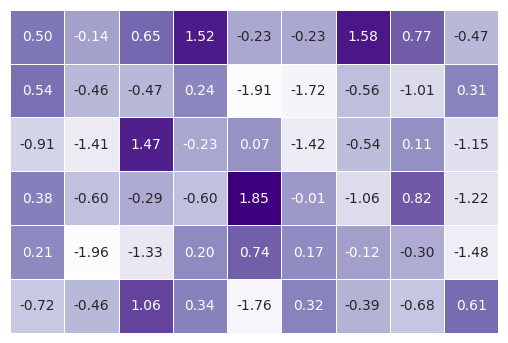

In [4]:
# 보조함수를 활용하여 행렬 시각화
plot_matrix(M)

### SVD 구현

In [5]:
def full_svd(matrix):
    # numpy를 이용한 SVD를 수행합니다.
    U, singular_values, V = np.linalg.svd(matrix)

    # numpy의 svd 결과로 나오는 sigma의 diagonal 성분을 가지고 diagonal matrix를 복원해줍니다.
    m, n = matrix.shape       # matrix 행렬의 차원
    sigma = np.zeros([m, n])  # matrix 행렬과 같은 차원의 영행렬을 만들어둡니다.

    rank = len(singular_values)  # rank 계산
    sigma[:rank, :rank] = np.diag(singular_values)  # rank까지만 복원
    return U, sigma, V.T

In [6]:
# SVD 수행
U, Sigma, V = full_svd(M)

Maximum diff:  3.552713678800501e-15


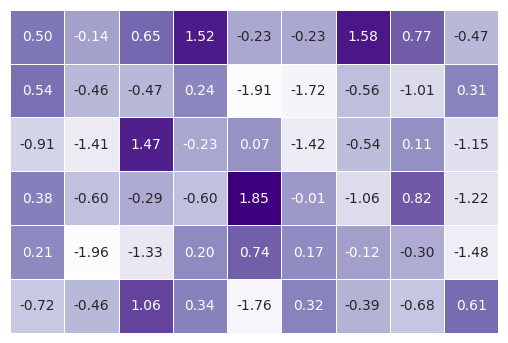

In [7]:
# 파이썬의 @ 연산자를 이용하면 np.dot 함수와 같은 행렬곱이나 내적을 편리하게 호출할 수 있습니다.
restored = U @ Sigma @ V.T # T는 전치행렬(transpose)

# 행렬 시각화
plot_matrix(restored)
print("Maximum diff: ", np.abs(M - restored).max())

### SVD 결과

In [8]:
print(U.shape, Sigma.shape, V.shape)

(6, 6) (6, 9) (9, 9)


1.3877787807814457e-16
0.9999999999999993


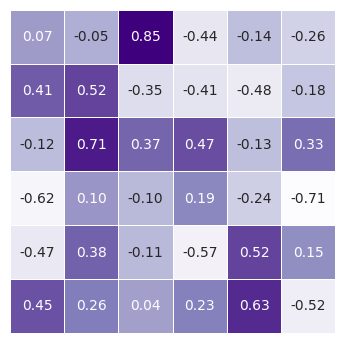

In [9]:
# 행렬 U를 시각화
plot_matrix(U)

# 행렬의 서로 다른 row를 골라 내적하면 0이 나옵니다.
print(U[1] @ U[3])

# 자기 자신과의 내적(벡터의 norm, 길이라고 생각할수 있는 개념)은 항상 1이 나옵니다.
print(U[1] @ U[1])

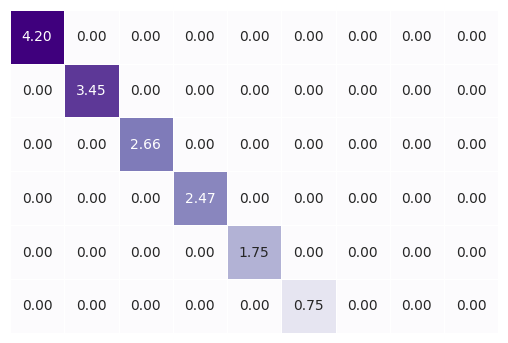

In [10]:
# Sigma 행렬 시각화
plot_matrix(Sigma)

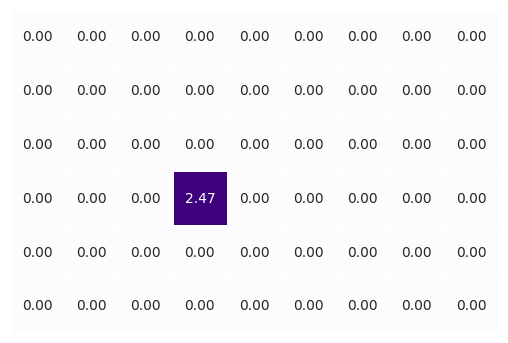

In [11]:
# 행렬의 (k,k)번째 원소만 남기고 나머지를 0으로 만드는 함수 정의
def select_diag(sigma, k):
    result = np.zeros_like(sigma)  # 영행렬 만들어두기
    result[k, k] = sigma[k, k]  # sigma 행렬의 (k,k) 원소만 남김
    return result

# Sigma의 (k,k)번째 원소만 남기고 나머지를 0으로 만들기
sigma_k = select_diag(Sigma, 3)
# 결과 행렬 시각화
plot_matrix(sigma_k)

Maximum diff:  3.3306690738754696e-15


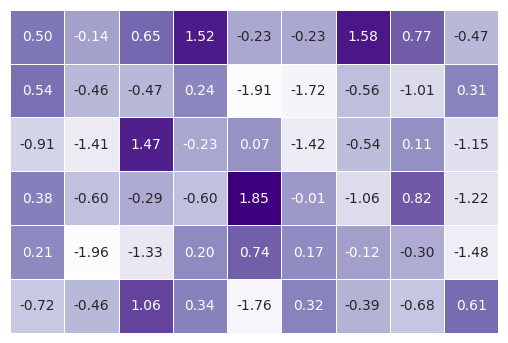

In [12]:
# 원래 행렬의 rank
r = np.linalg.matrix_rank(M)

# 결과 행렬을 미리 initialize
result = np.zeros_like(M)
for k in range(r):
    # Sigma_k를 계산 후 결과행렬에 더해줌.
    sigma_k = select_diag(Sigma, k)
    result += U @ sigma_k @ V.T

# 결과 행렬과 원래 행렬의 차이를 계산
print("Maximum diff: ", np.abs(M - result).max())
# 결과 행렬 시각화
plot_matrix(result)

Maximum diff:  3.3306690738754696e-15


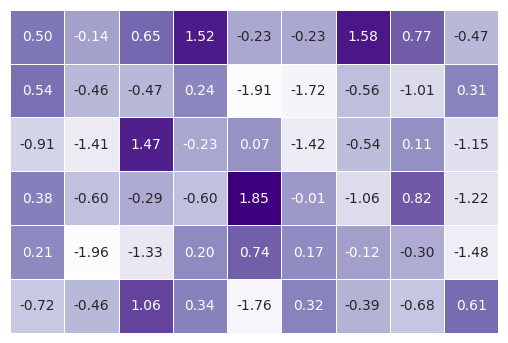

In [13]:
# k번째 열벡터를 가져오는 함수를 정의
def col_vec(matrix, k):
    return matrix[:, [k]]

# 원래 행렬의 rank
r = np.linalg.matrix_rank(M)

# 결과 행렬을 미리 initialize
result = np.zeros_like(M)
for k in range(r):
    # k번째 singular value, 스칼라값
    sig_k = Sigma[k, k]
    # U, V에서 한개의 column vector만을 가져와 사용해도 위 셀과 동일한 결과
    result += sig_k * col_vec(U, k) @ col_vec(V, k).T

# 결과 행렬과 원래 행렬의 차이를 계산
print("Maximum diff: ", np.abs(M - result).max())
# 결과 행렬 시각화
plot_matrix(result)

(6, 1)
(1, 9)
(6, 9)
Rank of resulting Rank-1 Matrix:  1


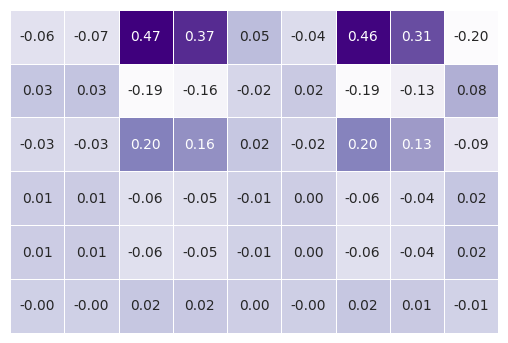

In [14]:
# 임의의 k를 선택합니다.
k = 2
# 곱해지는 U, V의 열벡터를 표시합니다.
print(col_vec(U, k).shape)
print(col_vec(V, k).T.shape)

# 두 벡터의 행렬곱으로 rank-1 matrix를 만듭니다.
rank1_mat = col_vec(U, k) @ col_vec(V, k).T

print(rank1_mat.shape)

# 이름처럼 rank는 1로 나옵니다.
print("Rank of resulting Rank-1 Matrix: ", np.linalg.matrix_rank(rank1_mat))

# matrix의 값들을 살펴보면, 첫번째 row에 스칼라곱을 해서 나머지 모든
# row를 만들수 있고(linearly dependence), 이는 column도 마찬가지입니다.
plot_matrix(rank1_mat)

### Truncated SVD를 통한 행렬의 rank 축소

In [15]:
def reduce_dim(M, n_components=None):
    # 주어진 행렬 M을 SVD합니다.
    U, Sigma, V = full_svd(M)

    r = np.linalg.matrix_rank(M)
    if n_components is None:
        # 몇개의 성분을 남길지 주어지지 않으면 아무것도 버리지 않고 전체 성분을 남깁니다.
        n_components = r

    # 남길 component 수가 전체 랭크보다 크면 에러 메시지 보여줍니다.
    assert n_components <= r, \
        f"남길 component의 개수({n_components})는 전체 랭크{r}보다 클 수 없습니다."

    # 결과 행렬을 미리 initialize
    result = np.zeros_like(M, dtype=np.float64)
    # 이번에는 r개가 아니라, 첫 n_components개까지만 rank-1 matrix들을 더해줍니다.
    for k in range(n_components):
        # k번째 singular value, 스칼라값과
        sig_k = Sigma[k, k]
        # rank1 행렬에 위 sig_k 스칼라값을 곱해 결과에 더함.
        result += sig_k * col_vec(U, k) @ col_vec(V, k).T
    return result

In [16]:
# 남길 성분의 수. 이 값을 0~6까지 직접 값을 조절해볼수 있습니다.
n_components = 5
size_scale = 0.6 # 비교해보기 편하도록 figure크기를 살짝 줄입니다.

# 원래 행렬의 rank를 구해봅니다.
print("Original rank: ", np.linalg.matrix_rank(M))

# TruncatedSVD를 수행해 n_component개의 성분만 남깁니다.
result = reduce_dim(M, n_components)

# TruncatedSVD 결과 행렬의 rank와 원본 행렬과의 값 차이를 프린트합니다.
print("Result rank: ", np.linalg.matrix_rank(result))
print("Maximum diff: ", np.abs(M - result).max())

Original rank:  6
Result rank:  5
Maximum diff:  0.3127401948455324


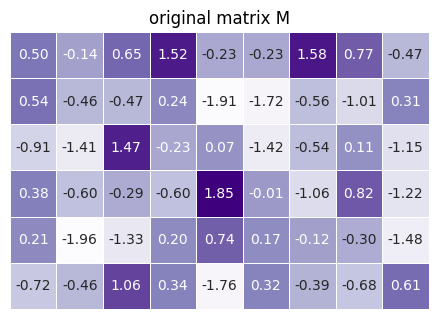

In [17]:
# 원래의 행렬
plot_matrix(M, size_scale=size_scale)
plt.title('original matrix M')  # 구분을 위해 시각화 제목 넣기
plt.show()                      # 그림 보여주기

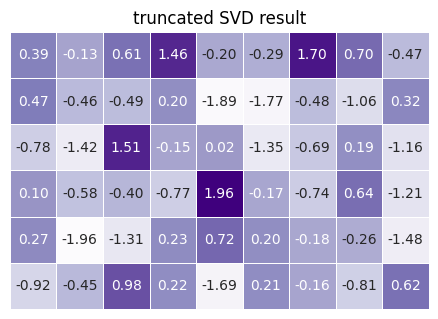

In [18]:
# truncated svd 결과 행렬
plot_matrix(result, size_scale=size_scale)
plt.title('truncated SVD result')  # 구분을 위해 시각화 제목 넣기
plt.show()               # 그림 보여주기

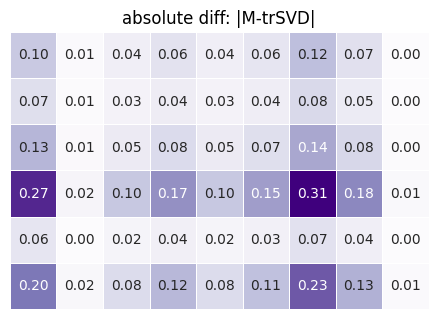

In [19]:
# 원래 행렬과의 차이(absolute diff)
plot_matrix(np.abs(M - result), size_scale=size_scale)
plt.title('absolute diff: |M-trSVD|')  # 구분을 위해 시각화 제목 넣기
plt.show()                  # 그림 보여주기

## PCA 구현 : EigenFace

In [20]:
# 데이터 불러오기
faces, _ = datasets.fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=random_state)

n_samples, n_features = faces.shape
print('데이터 수:', n_samples) # 데이터 수 확인
print('차원 수:', n_features) # 차원수 확인

데이터 수: 400
차원 수: 4096


In [21]:
# 첫번째 데이터 확인하기
faces[0, :]

array([0.1983471 , 0.23553719, 0.35123968, ..., 0.06198347, 0.12809917,
       0.09090909], dtype=float32)

In [22]:
# 데이터 범위 확인하기
print('평균:', faces.mean())
print('최댓값:', faces.max())
print('최솟값:', faces.min())

평균: 0.5470425
최댓값: 1.0
최솟값: 0.0


### 시각화 및 학습

```
matplotlib의 imshow함수가 0~1 범위의 float 숫자도 이미지로 쉽게 변환해볼 수 있는 기능을 지원하기 때문에, 
값의 범위를 0~255 범위의 픽셀값(int)으로 변환하는 작업은 하지 않아도 괜찮습니다. 
하지만 PCA분석을 위해서는 다음 각 데이터의 feature-wise, sample-wise로 평균이 모두 0이 되어야하므로 
이에 맞춰 다음과 같이 전처리를 수행해준 이후에는 별도의 scaling 과정을 거쳐야 제대로 이미지를 확인할 수 있습니다.
```

62-th row of matrix


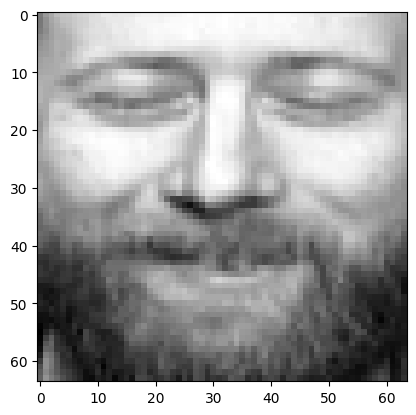

In [23]:
# 가져올 샘플의 번호를 랜덤으로 고름
index = np.random.choice(len(faces))
print(f"{index}-th row of matrix")

# 원본 이미지의 크기
img_h, img_w = (64, 64)

# 데이터(faces)에서 샘플(row)을 선택해 가져오기
face_vector = faces[index]

# 이미지를 원래의 크기로 변환한 후 display
face_image = face_vector.reshape(img_h, img_w)
plt.imshow(face_image, cmap="gray")

In [24]:
# 전체 샘플단위의 평균을 구하고, 이를 원본 데이터에서 빼서 평균을 0으로 맞춰줌
samplewise_mean = faces.mean(axis=0) # (4096, )
faces_centered = faces - samplewise_mean

# 각 이미지마다 모든 픽셀값의 평균을 구하고, 이를 원본 이미지에서 빼는 방식으로 평균을 0으로 맞춰줌
pixelwise_mean = faces_centered.mean(axis=1).reshape(n_samples, -1) # (400, )
faces_centered -= pixelwise_mean

In [25]:
# 시각화를 위한 함수 정의하기
def plot_faces(title, images, n_cols=3, n_rows=2, shuffle=False, cmap="gray", size_scale=2.0, random_seed=random_state, image_shape=(64, 64)):
    # plot할 이미지(벡터)들을 랜덤으로 선택
    if shuffle:
        np.random.seed(random_seed)
        indices = np.random.choice(len(images), n_cols * n_rows)
    else:
        indices = np.arange(n_cols * n_rows)

    # figure관련 설정
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(n_cols * size_scale, n_rows * size_scale),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)

    # 각 자리에 들어가는 얼굴 이미지를 plot
    for ax, idx in zip(axs.flat, indices):
        face_vec = images[idx]
        vmax = max(face_vec.max(), - face_vec.min())
        im = ax.imshow(
            face_vec.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        ax.axis("off")
    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()

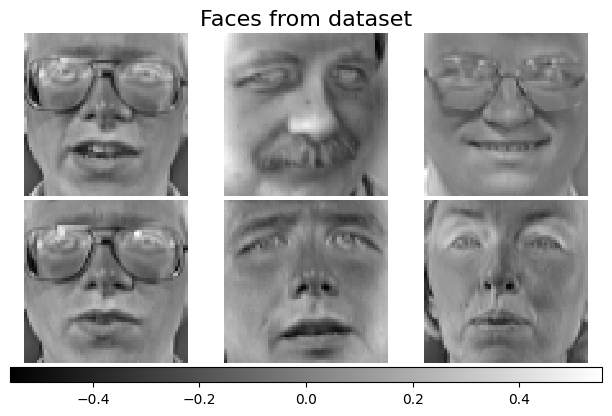

In [26]:
# 이미지 6개 시각화하기
plot_faces("Faces from dataset", faces_centered, shuffle=True, random_seed=random_state)

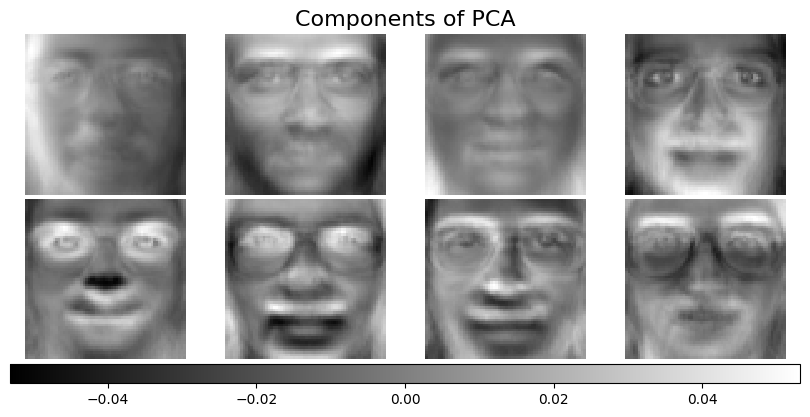

In [27]:
# 줄일 차원의 수 지정하기
n_components = 20

# PCA 수행하기
pca_estimator = PCA(n_components=n_components, svd_solver="full", whiten=True)
pca_estimator.fit(faces_centered)

# PCA 결과 (Eigenface) 시각화
plot_faces("Components of PCA", pca_estimator.components_, n_rows=2, n_cols=4)

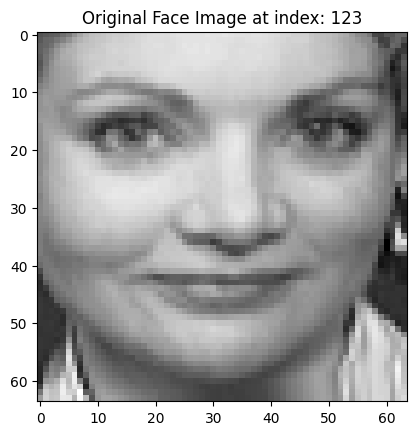

In [28]:
# 원본 이미지중에 임의로 하나를 고릅니다.
index = 123
indices = np.random.choice(n_samples, 6)
# 원본 이미지를 보여줍니다.
plt.title(f"Original Face Image at index: {index}")
plt.imshow(faces[index].reshape(64, 64), cmap="gray")

In [29]:
# 차원축소된 벡터 계산하기
reduced_vec = pca_estimator.transform(faces_centered[index].reshape(1, -1))
print(reduced_vec)
print('차원 축소된 벡터의 크기:', reduced_vec.shape)

[[-0.06170691  0.66552573  1.8887448  -1.0695809   0.593471   -0.66881865
   0.8582712  -1.5365746  -1.2286952  -1.2276291  -1.9903663  -0.039174
   1.1027545   2.0088654  -1.1147512  -2.4827428   0.11503679 -1.3612604
   2.4772232   1.3026693 ]]
차원 축소된 벡터의 크기: (1, 20)


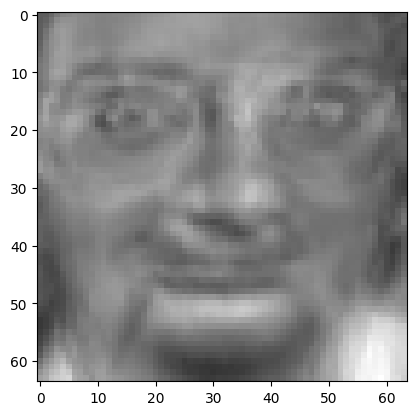

In [30]:
# 결과 행렬 미리 initialize
canvas = np.zeros([64, 64], dtype=np.float64)
for value, comp in zip(reduced_vec[0], pca_estimator.components_):
    # 각 component 벡터를 이미지 크기로 resize한 뒤, 이를 차원축소된 벡터의 각 값과 선형결합
    canvas += comp.reshape(64, 64) * value

vmax = max(canvas.max(), - canvas.min())

plt.imshow(canvas, cmap="gray", vmax=vmax, vmin=-vmax)

In [31]:
# 원본 이미지와 차원축소된 이미지들 비교하기
def compare_reduced_faces(title, images, index=123, n_components_list=[5, 20, 100], n_cols=4, n_rows=1, shuffle=False, cmap="gray", size_scale=2.5, random_seed=random_state, image_shape=(64, 64)):
    # 그림 관련 설정
    fig, axs = plt.subplots(
        nrows=n_rows, ncols=n_cols,
        figsize=(n_cols * size_scale, n_rows * size_scale),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")

    # 보여줄 이미지 선정
    face_vec = faces[index]

    # 첫 이미지로 원본 이미지를 보여줍니다.
    axs[0].set_title("Original Face Image", y=-0.2)
    axs[0].imshow(face_vec.reshape(image_shape), cmap="gray")
    axs[0].axis("off")

    # 다음 이미지부터는 PCA를 이용해 차원축소된 이미지를 보여줍니다.
    # 각 차원마다 보여주므로 줄일 차원의 수 리스트 중 하나씩 지정하여 PCA를 수행합니다.
    for img_index, n_components in enumerate(n_components_list):

        # PCA 수행하기
        pca_estimator = PCA(n_components=n_components, svd_solver="full", whiten=True)
        pca_estimator.fit(images)

        # 차원축소된 벡터 계산하기
        reduced_vec = pca_estimator.transform(face_vec.reshape(1, -1))
        # 결과 행렬 미리 initialize
        canvas = np.zeros([64, 64], dtype=np.float64)
        for value, comp in zip(reduced_vec[0], pca_estimator.components_):
            # 각 component 벡터를 이미지 크기로 resize한 뒤, 이를 차원축소된 벡터의 각 값과 선형결합
            canvas += comp.reshape(64, 64) * value

        # PCA 결과 (Eigenface) 시각화
        vmax = max(canvas.max(), - canvas.min())
        im = axs[img_index+1].imshow(
            canvas.reshape(image_shape),
            cmap=cmap,
            interpolation="nearest",
            vmin=-vmax,
            vmax=vmax,
        )
        axs[img_index+1].axis("off")
        axs[img_index+1].set_title(f'Dimension={n_components}', y=-0.2)

    # 최종 이미지 보여주기
    plt.suptitle(title + f': images at index {index}', fontsize=20)
    plt.show()

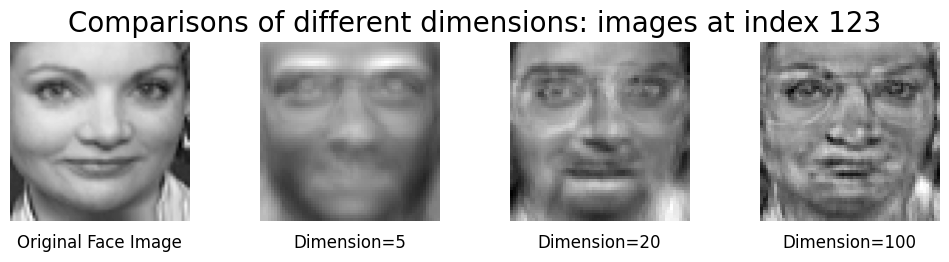

In [32]:
compare_reduced_faces('Comparisons of different dimensions', faces_centered, n_components_list=[5, 20, 100])

In [33]:
# singular value 확인하기
pca_estimator.singular_values_

array([67.12953 , 50.259655, 41.9929  , 37.271915, 31.780457, 28.802628,
       25.470306, 25.337257, 23.112791, 22.469475, 21.306612, 20.094727,
       19.481874, 18.365595, 17.794628, 17.228043, 16.356892, 15.426778,
       15.386468, 14.981874], dtype=float32)

In [34]:
# 기존 faces데이터셋과 같은 크기의 랜덤 정규분포 데이터를 생성
random_noises = np.random.randn(*faces_centered.shape)

# 이 랜덤 포인트에 대해 PCA 수행하기
pca_estimator = PCA(n_components=n_components, svd_solver="full", whiten=True)
pca_estimator.fit(random_noises)

PCA(n_components=20, svd_solver='full', whiten=True)

In [35]:
# singular value 확인하기
pca_estimator.singular_values_

array([83.24157638, 82.93622621, 82.7846978 , 82.6195065 , 82.53529899,
       82.26839417, 82.01940386, 81.78317142, 81.622672  , 81.40201307,
       81.31673342, 81.11152057, 81.02016682, 80.6688018 , 80.40678515,
       80.31850281, 80.2413019 , 79.95415883, 79.84057872, 79.72368299])

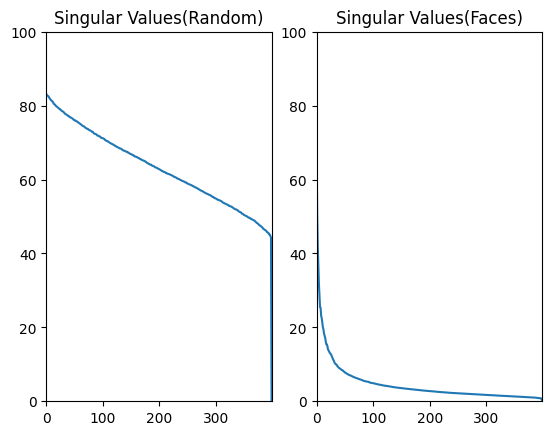

In [36]:
# 얼굴 데이터에 대해 최대 n_components로 PCA 수행하기
pca_faces = PCA(n_components=400, svd_solver="full", whiten=True)
pca_faces.fit(faces_centered)
sv_faces = pca_faces.singular_values_

# 랜덤 데이터에 대해 최대 n_components로 PCA 수행하기
pca_random = PCA(n_components=400, svd_solver="full", whiten=True)
pca_random.fit(random_noises)
sv_random = pca_random.singular_values_


# 각각의 singular value들을 plot해 비교.
plt.subplot(121)
plt.title("Singular Values(Random)")
plt.xlim(0, 399)
plt.ylim(0, 100)
plt.plot(sv_random)

plt.subplot(122)
plt.title("Singular Values(Faces)")
plt.xlim(0, 399)
plt.ylim(0, 100)
plt.plot(sv_faces)

## t-SNE(t-distributed Stochastic Neighbor Embedding)

In [37]:
# 데이터 불러오기
digits = datasets.load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape
print('데이터 수:', n_samples) # 데이터 수 확인
print('차원 수:', n_features) # 차원수 확인

데이터 수: 1083
차원 수: 64


In [38]:
# 첫번째 데이터 확인하기
X[[0]]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

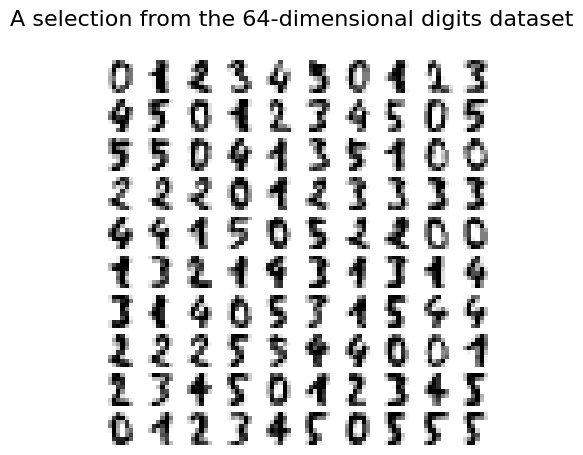

In [39]:
# 숫자 이미지 시각화
fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(5, 5))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(X[idx].reshape((8, 8)), cmap=plt.cm.binary)
    ax.axis("off")
_ = fig.suptitle("A selection from the 64-dimensional digits dataset", fontsize=16)

In [40]:
# plot helper 함수 정의
def plot_embedding(X, title):
    _, ax = plt.subplots()
    # 정규화
    X = MinMaxScaler().fit_transform(X)
    # 색깔로 숫자로 scatter 표시
    for digit in digits.target_names:
        ax.scatter(
            *X[y == digit].T,
            marker=f"${digit}$",
            s=60,
            color=plt.cm.Dark2(digit),
            alpha=0.425,
            zorder=2,
        )
    # 이미지 그림 표시
    shown_images = np.array([[1.0, 1.0]])
    for i in range(X.shape[0]):
        # 모든 숫자 임베딩을 scatter하고, 숫자 그룹에 annotation box를 보기
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        # 보기 쉽게 하기 위해 너무 가까운 데이터는 보여주지 않기
        if np.min(dist) < 4e-3:
            continue
        # 이미지 합치기
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), X[i]
        )
        imagebox.set(zorder=1)
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

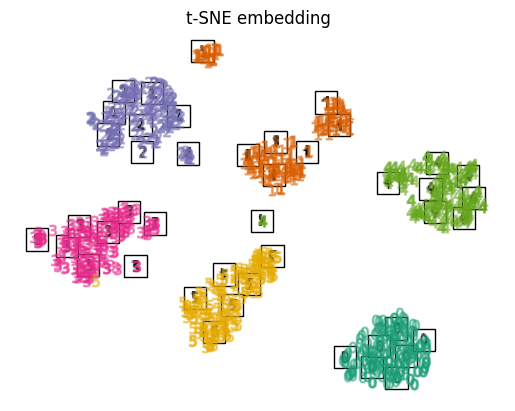

In [43]:
# pip install threadpoolctl==3.1.0 해야 실행 가능!!
# t-SNE 적용
transformer = TSNE(n_components=2, random_state=0)
projection = transformer.fit_transform(X, y)

# t-SNE 결과 시각화
plot_embedding(projection, 't-SNE embedding')
plt.show()

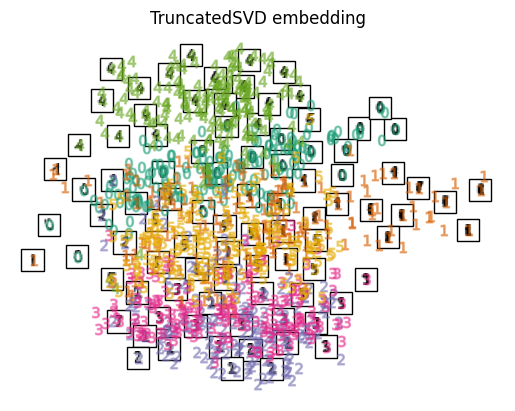

In [44]:
# Truncated SVD 적용
transformer = TruncatedSVD(n_components=2)
projection = transformer.fit_transform(X, y)

# TruncatedSVD 결과 시각화
plot_embedding(projection, 'TruncatedSVD embedding')
plt.show()